In [159]:
import sys
sys.path.append('..')
from a2c_ppo_acktr import algo, utils
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from evaluation import evaluate
from tqdm import tqdm

import matplotlib.pyplot as plt
    
%run model_evaluation

from a2c_ppo_acktr.storage import RolloutStorage
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr import algo, utils
from  a2c_ppo_acktr.model import Policy
import torch

import proplot as pplt
from collections import defaultdict

from sklearn.metrics.pairwise import cosine_similarity
'''
First 4 parameters are for shared recurrent layer. Can freeze these by setting
requires_grad = False
'''

def populate_rollouts(model, envs, rollouts, num_steps, seed=None, deterministic=False):
    if seed != None:
        torch.manual_seed(seed)

    for step in range(num_steps):
        #Generate rollouts for num_steps batch
        with torch.no_grad():
            outputs = model.act(rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                                rollouts.masks[step])
            action = outputs['action']
            value = outputs['value']
            action_log_prob = outputs['action_log_probs']
            recurrent_hidden_states = outputs['rnn_hxs']
            auxiliary_preds = outputs['auxiliary_preds']

        obs, reward, done, infos = envs.step(action)
        # if (reward != 0).any():
        #     print(reward, done, infos)
        masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
        bad_masks = torch.FloatTensor([[0.0] if 'bad_transition' in info.keys() else [1.0] for info in infos])
        
        auxiliary_truths = []
        for info in infos:
            if 'auxiliary' in info:
                if len(info['auxiliary'] > 0):
                    auxiliary_truths.append(info['auxiliary'])
        if len(auxiliary_truths) > 0:
            auxiliary_truths = torch.tensor(np.vstack(auxiliary_truths))
        else:
            auxiliary_truths = None

        rollouts.insert(obs, recurrent_hidden_states, action, action_log_prob, value, reward, masks, bad_masks,
                        auxiliary_preds, auxiliary_truths)
        
def clone_rollouts(copy, paste, num_steps, start=0, copy_first=True):
    if copy_first:
        #Copy the first steps of storage types that need it
        paste.obs[0].copy_(copy.obs[start])
        paste.recurrent_hidden_states[0].copy_(copy.recurrent_hidden_states[start])
        paste.masks[0].copy_(copy.masks[start])
        paste.bad_masks[0].copy_(copy.bad_masks[start])
        
    for step in range(num_steps):
        obs = copy.obs[step+start+1]
        recurrent_hidden_states = copy.recurrent_hidden_states[step+start+1]
        action = copy.actions[step+start]
        action_log_prob = copy.action_log_probs[step+start]
        value = copy.value_preds[step+start]
        reward = copy.rewards[step+start]
        masks = copy.masks[step+start+1]
        bad_masks = copy.bad_masks[step+start+1]
        paste.insert(obs, recurrent_hidden_states, action, action_log_prob, value, reward, masks, bad_masks)

        
def update_model(agent, rollouts, use_gae=False, gamma=0.99, gae_lambda=0.95,
                 after_update=True):
    
    #Compute last value to be used for the update
    with torch.no_grad():
        next_value = agent.actor_critic.get_value(rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                                            rollouts.masks[-1]).detach()
    
    rollouts.compute_returns(next_value, use_gae, gamma, gae_lambda)
    value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss = agent.update(rollouts)
    
    if after_update:
        rollouts.after_update()
        
    return value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss



def initialize_ppo_training(model=None, obs_rms=None, env_name='NavEnv-v0', env_kwargs={},
                            nn_base='FlexBase', nn_base_kwargs={}, recurrent=True,
                            num_steps=10, num_processes=1, seed=0, ppo_epoch=4, clip_param=0.5,
                            num_mini_batch=1, value_loss_coef=0.5, entropy_coef=0.01, 
                            auxiliary_loss_coef=0.3, gamma=0.99, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                            log_dir='/tmp/gym/', device=torch.device('cpu'), 
                            capture_video=False, take_optimizer_step=True,
                            normalize=True):
    
    #Initialize vectorized environments
    # envs = make_vec_envs(env_name, seed, num_processes, gamma, log_dir, device, False,
    #                      capture_video=capture_video, env_kwargs=env_kwargs)
    
    env = gym.make('NavEnv-v0', **env_kwargs)

    if model is None:
        model = Policy(env.observation_space.shape,
                       env.action_space,
                       base='FlexBase',
                       base_kwargs={'recurrent': recurrent,
                           **nn_base_kwargs})
        model.to(device)
    
    #Wrap model with an agent algorithm object
    # agent = algo.PPO(model, clip_param, ppo_epoch, num_mini_batch,
    agent = LoudPPO(model, clip_param, ppo_epoch, num_mini_batch,
                     value_loss_coef, entropy_coef, auxiliary_loss_coef, lr=lr,
                     eps=eps, max_grad_norm=max_grad_norm,
                     take_optimizer_step=take_optimizer_step)

    #Initialize storage
    rollouts = RolloutStorage(num_steps, num_processes, env.observation_space.shape, env.action_space,
                              model.recurrent_hidden_state_size, model.auxiliary_output_size)
    #Storage objects initializes a bunch of empty tensors to store information, e.g.
    #obs has shape (num_steps+1, num_processes, obs_shape)
    #rewards has shape (num_steps, num_processes, 1)
    
    envs = make_vec_envs(env_name, seed, num_processes, gamma, log_dir, device, False,
                         capture_video=capture_video, env_kwargs=env_kwargs)
    #If loading a previously trained model, pass an obs_rms object to set the vec envs to use
    
    if normalize:
        vec_norm = utils.get_vec_normalize(envs)
        if vec_norm is not None and obs_rms is not None:
            vec_norm.obs_rms = obs_rms

        
    #obs, recurrent_hidden_states, value_preds, returns all have batch size num_steps+1
    #rewards, action_log_probs, actions, masks, auxiliary_preds, auxiliary_truths all have batch size num_steps
    obs = envs.reset()
    rollouts.obs[0].copy_(obs)
    rollouts.to(device)
    
    return agent, envs, rollouts



def collect_batches_and_grads(agent, envs, rollouts, num_batches=1, seed=None, num_layers=None,
                             decompose_grads=False):
    rewarded = []
    value_losses = []
    action_losses = []
    num_rewards = []
    value_diffs = []

    params = list(agent.actor_critic.base.parameters())
    if num_layers == None:
        num_layers = len(list(params))

    if decompose_grads:
        grad_types = ['value', 'action', 'auxiliary', 'entropy']
        all_grads = {name: [] for name in grad_types}
        for name in grad_types:
            for i in range(num_layers):
                all_grads[name].append([])
    else:
        all_grads = []
        for i in range(num_layers):
            all_grads.append([])
        
    
    for n in range(num_batches):
        populate_rollouts(agent.actor_critic, envs, rollouts, rollouts.num_steps, seed=seed)
        
        agent.optimizer.zero_grad()
        next_value = agent.actor_critic.get_value(rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                                     rollouts.masks[-1]).detach()
        rollouts.compute_returns(next_value, False, 0.99, 0.95)
        
        
        if decompose_grads:
            value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss, \
                grads = agent.update(rollouts)
            
            for name in grad_types:
                for i in range(num_layers):
                    all_grads[name][i].append(grads[name][i])
        else:
            value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss = agent.update(rollouts)

            for i in range(num_layers):
                all_grads[i].append(params[i].grad.clone())
            
        rew = rollouts.rewards
        rewarded.append((rew != 0).any().item())
        num_rewards.append(len(rew[rew != 0]))
        value_losses.append(value_loss)
        action_losses.append(action_loss)
        
        value_diff = torch.sum(rollouts.returns - rollouts.value_preds)
        value_diffs.append(value_diff.item())
        rollouts.after_update()
    
    return {
        'all_grads': all_grads,
        'rewarded': rewarded,
        'value_losses': value_losses,
        'action_losses': action_losses,
        'rewards': num_rewards,
        'value_diff': value_diffs
    }

In [90]:
class LoudPPO():
    '''
    Variation on our trainer object that allows for printing of 
    some debugging information and more importantly allows us to compute
    gradients without taking the actual update step to network weights
    '''
    def __init__(self,
                 actor_critic,
                 clip_param,
                 ppo_epoch,
                 num_mini_batch,
                 value_loss_coef,
                 entropy_coef,
                 auxiliary_loss_coef=0,
                 lr=None,
                 eps=None,
                 max_grad_norm=None,
                 use_clipped_value_loss=True,
                 verbose=False,
                 take_optimizer_step=True):

        self.actor_critic = actor_critic

        self.clip_param = clip_param
        self.ppo_epoch = ppo_epoch
        self.num_mini_batch = num_mini_batch

        self.value_loss_coef = value_loss_coef
        self.entropy_coef = entropy_coef
        self.auxiliary_loss_coef = auxiliary_loss_coef

        self.max_grad_norm = max_grad_norm
        self.use_clipped_value_loss = use_clipped_value_loss

        self.optimizer = optim.Adam(actor_critic.parameters(), lr=lr, eps=eps)
        
        #Additional parameter that allows us to skip taking optimizer step so that
        #we can keep trajectories same for different batch sizes
        self.take_optimizer_step = take_optimizer_step
        self.verbose = verbose

    def update(self, rollouts):
        advantages = rollouts.returns[:-1] - rollouts.value_preds[:-1]
        advantages = (advantages - advantages.mean()) / (
            advantages.std() + 1e-5)

        value_loss_epoch = 0
        action_loss_epoch = 0
        dist_entropy_epoch = 0
        auxiliary_loss_epoch = 0

        clipfracs = []
        explained_vars = []
        
        num_update_steps = 0
        for e in range(self.ppo_epoch):
            if self.actor_critic.is_recurrent:
                data_generator = rollouts.recurrent_generator(
                    advantages, self.num_mini_batch)
            else:
                data_generator = rollouts.feed_forward_generator(
                    advantages, self.num_mini_batch)

            for sample in data_generator:
                num_update_steps += 1
                if self.verbose:
                    print(num_update_steps)
                obs_batch, recurrent_hidden_states_batch, actions_batch, \
                   value_preds_batch, return_batch, masks_batch, old_action_log_probs_batch, \
                    adv_targ, auxiliary_pred_batch, auxiliary_truth_batch = sample

                # Reshape to do in a single forward pass for all steps
                values, action_log_probs, dist_entropy, _, auxiliary_preds = self.actor_critic.evaluate_actions(
                    obs_batch, recurrent_hidden_states_batch, masks_batch,
                    actions_batch)

                logratio = action_log_probs - old_action_log_probs_batch 
                ratio = torch.exp(logratio)
                surr1 = ratio * adv_targ
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param,
                                    1.0 + self.clip_param) * adv_targ
                action_loss = -torch.min(surr1, surr2).mean()

                #Andy: compute approx kl
                with torch.no_grad():
                    # old_approx_kl = (-logratio).mean()
                    approx_kl = ((ratio - 1) - logratio).mean()
                    clipfracs += [
                        ((ratio - 1.0).abs() > self.clip_param).float().mean().item()
                    ]

                if self.use_clipped_value_loss:
                    value_pred_clipped = value_preds_batch + \
                        (values - value_preds_batch).clamp(-self.clip_param, self.clip_param)
                    value_losses = (values - return_batch).pow(2)
                    value_losses_clipped = (
                        value_pred_clipped - return_batch).pow(2)
                    value_loss = 0.5 * torch.max(value_losses,
                                                 value_losses_clipped).mean()
                else:
                    value_loss = 0.5 * (return_batch - values).pow(2).mean()
                
                if self.actor_critic.has_auxiliary:
                    auxiliary_loss = 0.5 * (auxiliary_truth_batch - auxiliary_preds).pow(2).mean()
                else:
                    auxiliary_loss = torch.zeros(1)
                # print(auxiliary_truth_batch, auxiliary_preds, auxiliary_loss)


                self.optimizer.zero_grad()
                (value_loss * self.value_loss_coef + action_loss + 
                 auxiliary_loss * self.auxiliary_loss_coef -
                 dist_entropy * self.entropy_coef).backward()
                nn.utils.clip_grad_norm_(self.actor_critic.parameters(),
                                         self.max_grad_norm)
                if self.take_optimizer_step:
                    self.optimizer.step()

                value_loss_epoch += value_loss.item()
                action_loss_epoch += action_loss.item()
                dist_entropy_epoch += dist_entropy.item()
                auxiliary_loss_epoch += auxiliary_loss.item()

        num_updates = self.ppo_epoch * self.num_mini_batch

        value_loss_epoch /= num_updates
        action_loss_epoch /= num_updates
        dist_entropy_epoch /= num_updates



        return value_loss_epoch, action_loss_epoch, dist_entropy_epoch, \
            approx_kl, clipfracs, auxiliary_loss_epoch

    
    
class DecomposeGradPPO():
    '''
    Variation on our trainer object that further keeps track of grads induced
    by each individual loss and returns them on the update function
    Note this is going to assume that we only have one single ppo_epoch and one
    minibatch 
    '''
    def __init__(self,
                 actor_critic,
                 clip_param,
                 ppo_epoch,
                 num_mini_batch,
                 value_loss_coef,
                 entropy_coef,
                 auxiliary_loss_coef=0,
                 lr=None,
                 eps=None,
                 max_grad_norm=None,
                 use_clipped_value_loss=True,
                 verbose=False,
                 take_optimizer_step=True):

        self.actor_critic = actor_critic

        self.clip_param = clip_param
        self.ppo_epoch = ppo_epoch
        self.num_mini_batch = num_mini_batch

        self.value_loss_coef = value_loss_coef
        self.entropy_coef = entropy_coef
        self.auxiliary_loss_coef = auxiliary_loss_coef

        self.max_grad_norm = max_grad_norm
        self.use_clipped_value_loss = use_clipped_value_loss

        self.optimizer = optim.Adam(actor_critic.parameters(), lr=lr, eps=eps)
        
        #Additional parameter that allows us to skip taking optimizer step so that
        #we can keep trajectories same for different batch sizes
        self.take_optimizer_step = take_optimizer_step
        self.verbose = verbose

    def update(self, rollouts):
        advantages = rollouts.returns[:-1] - rollouts.value_preds[:-1]
        advantages = (advantages - advantages.mean()) / (
            advantages.std() + 1e-5)

        value_loss_epoch = 0
        action_loss_epoch = 0
        dist_entropy_epoch = 0
        auxiliary_loss_epoch = 0

        clipfracs = []
        explained_vars = []
        
        num_update_steps = 0
        for e in range(self.ppo_epoch):
            if self.actor_critic.is_recurrent:
                data_generator = rollouts.recurrent_generator(
                    advantages, self.num_mini_batch)
            else:
                data_generator = rollouts.feed_forward_generator(
                    advantages, self.num_mini_batch)

            for sample in data_generator:
                num_update_steps += 1
                if self.verbose:
                    print(num_update_steps)
                obs_batch, recurrent_hidden_states_batch, actions_batch, \
                   value_preds_batch, return_batch, masks_batch, old_action_log_probs_batch, \
                    adv_targ, auxiliary_pred_batch, auxiliary_truth_batch = sample

                # Reshape to do in a single forward pass for all steps
                values, action_log_probs, dist_entropy, _, auxiliary_preds = self.actor_critic.evaluate_actions(
                    obs_batch, recurrent_hidden_states_batch, masks_batch,
                    actions_batch)

                logratio = action_log_probs - old_action_log_probs_batch 
                ratio = torch.exp(logratio)
                surr1 = ratio * adv_targ
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param,
                                    1.0 + self.clip_param) * adv_targ
                action_loss = -torch.min(surr1, surr2).mean()

                #Andy: compute approx kl
                with torch.no_grad():
                    # old_approx_kl = (-logratio).mean()
                    approx_kl = ((ratio - 1) - logratio).mean()
                    clipfracs += [
                        ((ratio - 1.0).abs() > self.clip_param).float().mean().item()
                    ]

                if self.use_clipped_value_loss:
                    value_pred_clipped = value_preds_batch + \
                        (values - value_preds_batch).clamp(-self.clip_param, self.clip_param)
                    value_losses = (values - return_batch).pow(2)
                    value_losses_clipped = (
                        value_pred_clipped - return_batch).pow(2)
                    value_loss = 0.5 * torch.max(value_losses,
                                                 value_losses_clipped).mean()
                else:
                    value_loss = 0.5 * (return_batch - values).pow(2).mean()
                
                if self.actor_critic.has_auxiliary:
                    auxiliary_loss = 0.5 * (auxiliary_truth_batch - auxiliary_preds).pow(2).mean()
                else:
                    auxiliary_loss = torch.zeros(1)
                # print(auxiliary_truth_batch, auxiliary_preds, auxiliary_loss)


                # (value_loss * self.value_loss_coef + action_loss + 
                #  auxiliary_loss * self.auxiliary_loss_coef -
                #  dist_entropy * self.entropy_coef).backward()             
                params = list(self.actor_critic.parameters())
                num_param_layers = len(params)

                loss_names = ['value', 'action', 'auxiliary', 'entropy']
                losses = [
                    value_loss*self.value_loss_coef,
                    action_loss,
                    auxiliary_loss*self.auxiliary_loss_coef,
                    -dist_entropy
                ]
                grads = defaultdict(list)
                
                for i, loss in enumerate(losses):
                    name = loss_names[i]
                    self.optimizer.zero_grad()
                    if loss.grad_fn != None:
                        loss.backward(retain_graph=True)
                    for param in params:
                        if param.grad == None:
                            grad = torch.zeros(param.shape)
                        else:
                            grad = param.grad.clone()
                        grads[name].append(grad)
                                
                nn.utils.clip_grad_norm_(self.actor_critic.parameters(),
                                         self.max_grad_norm)
                if self.take_optimizer_step:
                    self.optimizer.step()

                value_loss_epoch += value_loss.item()
                action_loss_epoch += action_loss.item()
                dist_entropy_epoch += dist_entropy.item()
                auxiliary_loss_epoch += auxiliary_loss.item()

        num_updates = self.ppo_epoch * self.num_mini_batch

        value_loss_epoch /= num_updates
        action_loss_epoch /= num_updates
        dist_entropy_epoch /= num_updates



        return value_loss_epoch, action_loss_epoch, dist_entropy_epoch, \
            approx_kl, clipfracs, auxiliary_loss_epoch, grads

In [23]:
trial_name = 'nav_pdistal_width16batch200'
trial = 0
checkpoint_folder = '../trained_models/checkpoint/nav_poster_netstructure/'
model_folder ='nav_poster_netstructure/'


path = checkpoint_folder + f'{trial_name}_t{trial}'
# Get env_kwargs
model_name = f'{model_folder}{trial_name}'
print(model_name)
_, _, kwargs = load_model_and_env(model_name, trial)

checkpoints = list(Path(path).iterdir())



'''Collect batch gradients for different checkpoints and batch sizes
    Fixed 50 batches regardless of batch size so we have potentially less noise
    in larger batches
'''

#reorder by number
chks = [int(checkpoint.name.split('.pt')[0]) for checkpoint in checkpoints]
chks = np.sort(np.array(chks))
parent = checkpoints[0].parent

#Override with just a few checkpoints
chks = [0, 20, 40, 60, 80, 100, 200]
# chks = [100]
ordered_checkpoints = [parent/f'{chk}.pt' for chk in chks]


batch_sizes = [8, 32, 128, 512]
num_processes = 16

all_grads = {}
all_rewarded = {}
all_rewards = {}
all_value_losses = {}
all_action_losses = {}
all_value_diffs = {}


env_kwargs = pickle.load(open('../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_env', 'rb'))
envs = make_vec_envs('NavEnv-v0', 0, num_processes, 0.99, '/tmp/gym/', torch.device('cpu'),
                    False, env_kwargs=env_kwargs)
obs = envs.reset()

for chk in chks:
    all_grads[chk] = {batch: [] for batch in batch_sizes}
    all_rewarded[chk] = {batch: [] for batch in batch_sizes}
    all_rewards[chk] = {batch: [] for batch in batch_sizes}
    all_value_losses[chk] = {batch: [] for batch in batch_sizes}
    all_action_losses[chk] = {batch: [] for batch in batch_sizes}
    all_value_diffs[chk] = {batch: [] for batch in batch_sizes}
for i, checkpoint in enumerate(tqdm(ordered_checkpoints)):
    chk = chks[i]
    model, obs_rms = torch.load(checkpoint)
    agent = LoudPPO(model, 0.5, 4, 1, 0.5, 0.01, 0.3, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                    take_optimizer_step=False)
    params = list(agent.actor_critic.base.parameters())

    for batch in batch_sizes:
        rollouts = RolloutStorage(batch, num_processes, envs.observation_space.shape, envs.action_space,
                                  model.recurrent_hidden_state_size, model.auxiliary_output_size)
        rollouts.obs[0].copy_(obs)
        
        # num_batches = collect_steps // batch
        num_batches = 50
        res = collect_batches_and_grads(agent, envs, rollouts, num_batches=num_batches)
        all_grads[chk][batch] = res['all_grads']
        all_rewarded[chk][batch] = res['rewarded']
        all_rewards[chk][batch] = res['rewards']
        all_value_losses[chk][batch] = res['value_losses']
        all_action_losses[chk][batch] = res['action_losses']
        all_value_diffs[chk][batch] = res['value_diff']
        
        obs = rollouts.obs[-1]
        
        
        
all_results = {
    'all_grads': all_grads,
    'all_rewarded': all_rewarded,
    'all_rewards': all_rewards,
    'all_value_losses': all_value_losses,
    'all_action_losses': all_action_losses,
    'all_value_diffs': all_value_diffs
}
pickle.dump(all_results, open('data/grads/width16t0_checkpoint_grads', 'wb'))

nav_poster_netstructure/nav_pdistal_width16batch200


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [15:32<00:00, 133.18s/it]


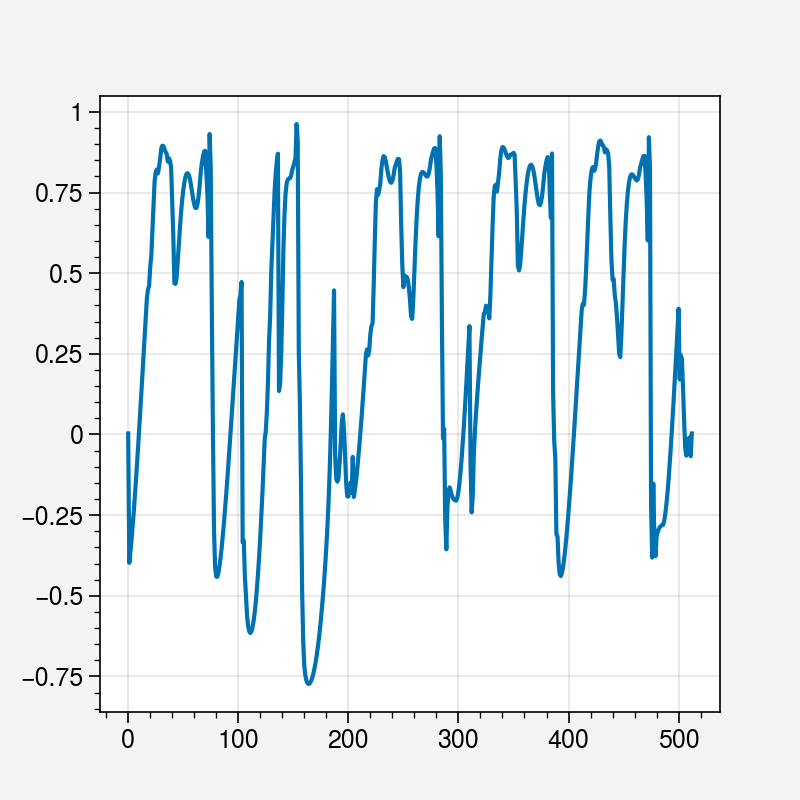

In [16]:
plt.plot(rollouts.recurrent_hidden_states[:, 0, 0])

In [169]:
# '''Code to test DecomposeGradPPO'''

# trial_name = 'nav_pdistal_width16batch200'
# trial = 0
# checkpoint_folder = '../trained_models/checkpoint/nav_poster_netstructure/'
# model_folder ='nav_poster_netstructure/'


# path = checkpoint_folder + f'{trial_name}_t{trial}'
# # Get env_kwargs
# model_name = f'{model_folder}{trial_name}'
# print(model_name)
# _, _, kwargs = load_model_and_env(model_name, trial)

# checkpoints = list(Path(path).iterdir())
# parent = checkpoints[0].parent

# #Override with just a few checkpoints
# chks = [0, 20, 40, 60, 80, 100, 200]
# ordered_checkpoints = [parent/f'{chk}.pt' for chk in chks]

# env_kwargs = pickle.load(open('../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_env', 'rb'))






# model_name = 'nav_pdistal_widthaux/nav_pdistal_width16auxgoaldist'
# model_name = 'nav_pdistal_widthaux/nav_pdistal_width16auxwall0'
model_name = 'nav_poster_netstructure/nav_pdistal_width16batch200'
num_processes = 1
model, obs_rms, env_kwargs = load_model_and_env(model_name, 0)
envs = make_vec_envs('NavEnv-v0', 0, num_processes, 0.99, '/tmp/gym/', torch.device('cpu'),
                    False, env_kwargs=env_kwargs)
obs = envs.reset()

chk = 60
batch = 128
agent = DecomposeGradPPO(model, 0.5, 4, 1, 0.5, 0.01, 0.3, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                    take_optimizer_step=False)
# agent = LoudPPO(model, 0.5, 4, 1, 0.5, 0.01, 0.3, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
#                     take_optimizer_step=False)
params = list(agent.actor_critic.base.parameters())

rollouts = RolloutStorage(batch, num_processes, envs.observation_space.shape, envs.action_space,
                          model.recurrent_hidden_state_size, model.auxiliary_output_size)
rollouts.obs[0].copy_(obs)


populate_rollouts(agent.actor_critic, envs, rollouts, num_steps=batch)
obs = rollouts.obs[-1]

In [171]:
len(list(model.base.parameters()))

14

In [161]:
res = collect_batches_and_grads(agent, envs, rollouts, num_batches=5, decompose_grads=True)

In [152]:
len(list(agent.actor_critic.base.parameters()))

16

In [111]:
num_steps = 5
for step in range(num_steps):
    #Generate rollouts for num_steps batch
    with torch.no_grad():
        outputs = model.act(rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                            rollouts.masks[step])
        action = outputs['action']
        value = outputs['value']
        action_log_prob = outputs['action_log_probs']
        recurrent_hidden_states = outputs['rnn_hxs']
        auxiliary_preds = outputs['auxiliary_preds']

    obs, reward, done, infos = envs.step(action)
    # if (reward != 0).any():
    #     print(reward, done, infos)
    masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
    bad_masks = torch.FloatTensor([[0.0] if 'bad_transition' in info.keys() else [1.0] for info in infos])

    auxiliary_truths = []
    for info in infos:
        if 'auxiliary' in info:
            if len(info['auxiliary'] > 0):
                auxiliary_truths.append(info['auxiliary'])
    if len(auxiliary_truths) > 0:
        auxiliary_truths = torch.tensor(np.vstack(auxiliary_truths))
    else:
        auxiliary_truths = None

In [157]:
agent.optimizer.zero_grad()
next_value = agent.actor_critic.get_value(rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                             rollouts.masks[-1]).detach()
rollouts.compute_returns(next_value, False, 0.99, 0.95)
res = agent.update(rollouts)

In [158]:
len(res[-1]['auxiliary'])

18

In [77]:
advantages = rollouts.returns[:-1] - rollouts.value_preds[:-1]
advantages = (advantages - advantages.mean()) / (
    advantages.std() + 1e-5)

value_loss_epoch = 0
action_loss_epoch = 0
dist_entropy_epoch = 0
auxiliary_loss_epoch = 0

clipfracs = []
explained_vars = []

num_update_steps = 0

data_generator = rollouts.recurrent_generator(advantages, 1)

for sample in data_generator:
    num_update_steps += 1
    obs_batch, recurrent_hidden_states_batch, actions_batch, \
       value_preds_batch, return_batch, masks_batch, old_action_log_probs_batch, \
        adv_targ, auxiliary_pred_batch, auxiliary_truth_batch = sample

    # Reshape to do in a single forward pass for all steps
    values, action_log_probs, dist_entropy, _, auxiliary_preds = agent.actor_critic.evaluate_actions(
        obs_batch, recurrent_hidden_states_batch, masks_batch,
        actions_batch)

    logratio = action_log_probs - old_action_log_probs_batch 
    ratio = torch.exp(logratio)
    surr1 = ratio * adv_targ
    surr2 = torch.clamp(ratio, 1.0 - agent.clip_param,
                        1.0 + agent.clip_param) * adv_targ
    action_loss = -torch.min(surr1, surr2).mean()

    #Andy: compute approx kl
    with torch.no_grad():
        # old_approx_kl = (-logratio).mean()
        approx_kl = ((ratio - 1) - logratio).mean()
        clipfracs += [
            ((ratio - 1.0).abs() > agent.clip_param).float().mean().item()
        ]

    if agent.use_clipped_value_loss:
        value_pred_clipped = value_preds_batch + \
            (values - value_preds_batch).clamp(-agent.clip_param, agent.clip_param)
        value_losses = (values - return_batch).pow(2)
        value_losses_clipped = (
            value_pred_clipped - return_batch).pow(2)
        value_loss = 0.5 * torch.max(value_losses,
                                     value_losses_clipped).mean()
    else:
        value_loss = 0.5 * (return_batch - values).pow(2).mean()

    if agent.actor_critic.has_auxiliary:
        auxiliary_loss = 0.5 * (auxiliary_truth_batch - auxiliary_preds).pow(2).mean()
    else:
        auxiliary_loss = torch.zeros(1)
    # print(auxiliary_truth_batch, auxiliary_preds, auxiliary_loss)


In [78]:
value_loss

tensor(6.1723, grad_fn=<MulBackward0>)

In [79]:
action_loss

tensor(-7.4506e-09, grad_fn=<NegBackward0>)

In [82]:
auxiliary_loss.backward(retain_graph=True)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [85]:
auxiliary_loss.grad_fn == None

True

In [84]:
dist_entropy.grad_fn

In [75]:
agent.optimizer.zero_grad()

In [71]:
value_loss.backward(retain_graph=True)

In [72]:
params[0].grad

tensor([[-2.2816e-02, -2.5831e-02, -3.2841e-02,  ...,  2.9908e-02,
          9.4009e-03, -9.5914e-03],
        [-4.6790e-03, -5.1474e-03, -9.9367e-03,  ..., -2.2770e-02,
         -2.1531e-02, -2.0370e-02],
        [ 7.6236e-04,  5.5773e-04,  6.1747e-04,  ..., -7.5614e-03,
         -6.7090e-03, -6.1472e-03],
        ...,
        [-9.3868e-02, -7.9452e-02, -1.0297e-01,  ...,  3.3399e-01,
          3.6262e-01,  3.9712e-01],
        [-1.1651e-02, -1.8015e-02, -2.5842e-02,  ..., -2.2392e-01,
         -1.9609e-01, -1.7189e-01],
        [ 1.8872e-01,  1.5661e-01,  2.0184e-01,  ..., -6.8310e-01,
         -7.4808e-01, -7.9729e-01]])

In [76]:
action_loss.backward(retain_graph=True)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [74]:
params[0].grad

tensor([[-2.2863e-02, -2.5857e-02, -3.2872e-02,  ...,  3.0017e-02,
          9.4238e-03, -9.5273e-03],
        [-4.6822e-03, -5.1408e-03, -9.9219e-03,  ..., -2.2759e-02,
         -2.1544e-02, -2.0404e-02],
        [ 4.8525e-04,  3.3310e-04,  3.2592e-04,  ..., -8.4595e-03,
         -7.6069e-03, -6.9281e-03],
        ...,
        [-9.3259e-02, -7.8974e-02, -1.0218e-01,  ...,  3.4074e-01,
          3.6838e-01,  4.0246e-01],
        [-9.7065e-03, -1.6263e-02, -2.3524e-02,  ..., -2.2007e-01,
         -1.8936e-01, -1.6456e-01],
        [ 1.8770e-01,  1.5581e-01,  2.0074e-01,  ..., -6.8556e-01,
         -7.5018e-01, -7.9875e-01]])

In [34]:
for i, param in enumerate(params):
    print(i)
    param.grad.clone()

0
1
2
3
4
5
6


AttributeError: 'NoneType' object has no attribute 'clone'

In [37]:
params[0].grad.shape

torch.Size([48, 24])

In [38]:
params[0].shape

torch.Size([48, 24])

In [40]:
torch.zeros(params[0].shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [42]:
params[0].grad.clone()

tensor([[-1.0577e-02, -1.1705e-02, -1.6375e-02,  ...,  1.3445e-02,
         -8.5705e-04, -1.1964e-02],
        [-2.1936e-03, -2.1443e-03, -5.0916e-03,  ..., -1.1117e-02,
         -1.0213e-02, -9.2405e-03],
        [ 1.5853e-04,  3.2106e-04,  3.7400e-04,  ..., -5.1833e-03,
         -3.9617e-03, -2.9430e-03],
        ...,
        [-5.1467e-02, -4.0960e-02, -5.8323e-02,  ...,  2.0874e-01,
          2.0680e-01,  2.1537e-01],
        [-1.6537e-02, -1.8630e-02, -2.6251e-02,  ..., -9.4264e-02,
         -8.1778e-02, -7.3334e-02],
        [ 9.4570e-02,  7.5426e-02,  1.0628e-01,  ..., -3.5127e-01,
         -4.0363e-01, -4.5377e-01]])

In [39]:
params[6].grad == None

True

In [33]:
param

Parameter containing:
tensor([[ 0.2650, -0.2887, -0.0323, -0.0139, -0.4340,  0.2175,  0.1034, -0.5971,
          0.4163, -0.3875,  0.4444,  0.3800, -0.0152,  0.0666,  0.0670, -0.7296],
        [-0.3624,  0.2930,  0.7528,  0.2005, -0.1305,  0.3574,  0.4514,  0.1144,
          0.0577, -0.3460, -0.5272,  0.4880,  0.0734, -0.3184, -0.7039,  0.0203],
        [-0.1418,  0.2815,  0.8855, -0.2624, -0.1304, -0.6288,  0.0846, -0.8276,
         -0.2448,  0.1493, -0.4847,  0.2531, -0.2307,  0.4756,  0.1314, -0.0034],
        [ 0.0135, -0.5762, -0.1502, -0.5846,  0.3173, -0.3075,  0.0498, -0.2627,
          0.2343, -0.1240, -1.0310,  0.4906, -0.1034, -0.1321, -0.4696, -0.0745],
        [ 0.9805,  0.0953,  0.5195, -0.2256,  0.6118, -0.0283,  0.5335, -0.0814,
         -0.1870, -0.2117, -0.0432,  0.5639,  0.3232, -0.0416,  0.1928,  0.4208],
        [-0.4288,  0.1912, -0.0440, -0.0407,  0.1640,  0.4900, -0.1749, -0.1757,
          0.4153, -0.5367, -0.3752, -0.2423,  0.8495,  0.5222,  0.5443,  0.2808],


# Gaussian heatmap functions

In [1]:
import pickle

In [2]:
checkpoint_data = pickle.load(open('data/pdistal_widthaux_heatmap/nav_pdistal_width16auxwall0', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'data/pdistal_widthaux_heatmap/nav_pdistal_width16auxwall0'

In [4]:
from pathlib import Path

In [13]:
import torch
torch.load(Path(checkpoint_folder)/'0.pt')

ModuleNotFoundError: No module named 'a2c_ppo_acktr'

In [8]:
checkpoint_folder = '../trained_models/checkpoint/nav_pdistal_width16auxwall01_t0'
[int(chk.name.split('.pt')[0]) for chk in list(Path(checkpoint_folder).iterdir())]

[0,
 10,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 20,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 30,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 399,
 40,
 50,
 60,
 70,
 80,
 90]